# Heart Disease Dataset
The UCI Heart Disease dataset ([Link](https://archive.ics.uci.edu/dataset/45/heart+disease)) is a well-known resource in the machine learning community, frequently utilised for developing and benchmarking classification models aimed at predicting heart disease presence. 

The target variable indicates the presence of heart disease, with values ranging from 0 (no presence) to 4 (severe presence), but this analysis will simplify this to a binary classification: 0 for absence and 1 for presence of heart disease. 

## Importing Packages

In [405]:
from ucimlrepo import fetch_ucirepo 

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

import graphviz

from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay


## Preparing the Datasets
### 0. Importing the Datasets
Fetch the 'Heart Disease' dataset from UCI.

In [406]:
heart_disease = fetch_ucirepo(id=45) 

### 1. Setting Up the Training and Test Datasets
We will split the original dataset into 4 different splitting strategies, with the proportion of training and test as follows: 40/60, 60/40, 80/20, and 90/10.

First, we construct a dataframe from the original dataset for easier manipulation and split it into feature and label columns, as the target we are considering now is `num`.

In [407]:
X = heart_disease.data.features 
y = heart_disease.data.targets 

# Converting the data to a dataframe for easier manipulation
data = pd.concat([X, y], axis=1)
data = data.dropna()

target = 'num'

# Simplifying the target column to binary classification
data[target] = data[target].apply(lambda x: 1 if x > 0 else 0)

X = data.drop(columns=target)
y = data[target]

Then the feature and label are split into 4 splitting strategies as mentioned above.

In [408]:
training_splits = {
    "40/60": 0.4,
    "60/40": 0.6,
    "80/20": 0.8,
    "90/10": 0.9,
}

datasets = {}

for ratio, training_split in training_splits.items():
    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=1-training_split,
        train_size=training_split,
        shuffle=True,
        stratify=y,
        random_state=42
    )

    datasets[ratio] = {}
    datasets[ratio]['X_train'] = X_train
    datasets[ratio]['X_test'] = X_test
    datasets[ratio]['y_train'] = y_train
    datasets[ratio]['y_test'] = y_test

After splitting the datasets, the visualization of the class distribution is as follows.

#### Original Set

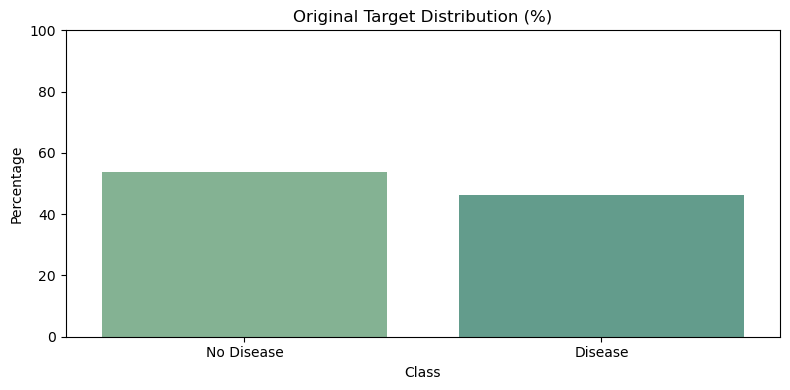

In [409]:
custom_labels = ['No Disease', 'Disease']

original_pct = y.value_counts(normalize=True) * 100
original_df = pd.DataFrame({
    'Class': custom_labels,
    'Percentage': original_pct.values
})

sns.set_palette('crest')
plt.figure(figsize=(8, 4))
sns.barplot(data=original_df, x='Class', y='Percentage', hue='Class', legend=False)
plt.title('Original Target Distribution (%)')

plt.xlabel('Class')
plt.ylabel('Percentage')
plt.ylim(0, 100)

plt.tight_layout()
plt.show()


#### Training Set

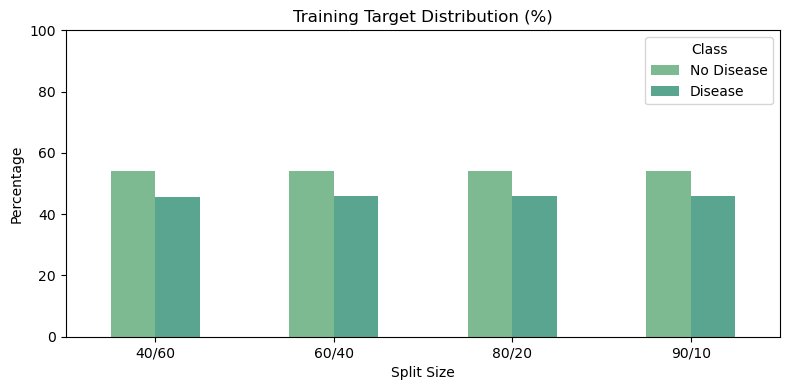

In [410]:
train_distributions = {}

for ratio, dataset in datasets.items():
    label_train = dataset['y_train']
    train_pct = label_train.value_counts(normalize=True) * 100
    train_distributions[ratio] = train_pct

train_df = pd.DataFrame(train_distributions).T

train_df.plot(kind='bar', figsize=(8, 4), legend=True)
plt.legend(custom_labels, title='Class')
plt.title("Training Target Distribution (%)")
plt.ylim(0, 100)
plt.ylabel("Percentage")
plt.xlabel("Split Size")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

#### Test Set

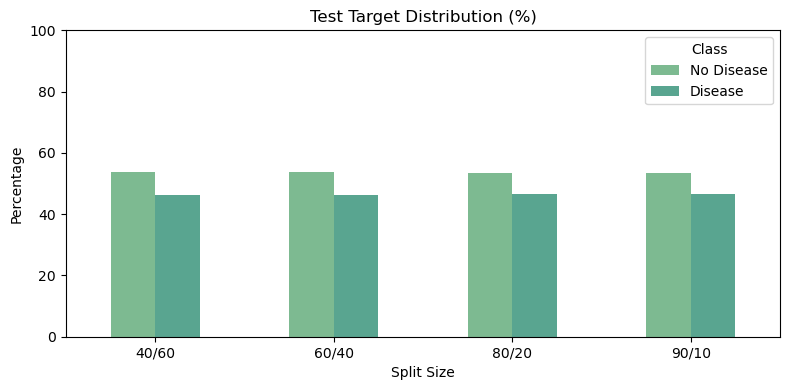

In [411]:
test_distributions = {}

for ratio, dataset in datasets.items():
    label_test = dataset['y_test']
    test_pct = label_test.value_counts(normalize=True) * 100
    test_distributions[ratio] = test_pct

test_df = pd.DataFrame(test_distributions).T

test_df.plot(kind='bar', figsize=(8, 4), legend=True)
plt.legend(custom_labels, title='Class')
plt.title("Test Target Distribution (%)")
plt.ylim(0, 100)
plt.ylabel("Percentage")
plt.xlabel("Split Size")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


As can be seen from three plots above, the dataset is relatively balanced across both training and test splits, which indicates that the preparation was appropriate.

### 2. Building the Decision Tree Classifiers

After preparing the datasets, we now fit a Decision Tree Classifier to each training set and visualize the decision tree result.

#### Model Training
We apply the `DecisionTreeClassifier` on each splitted subsets.

In [412]:
models = {}

for ratio, dataset in datasets.items():
    model = tree.DecisionTreeClassifier(criterion='entropy', random_state=42)
    feature_train, label_train = dataset['X_train'], dataset['y_train']
    model.fit(feature_train, label_train)

    models[ratio] = model

#### Visualization
The visualization of the resulting decision trees is processed with Graphviz.

In [413]:
graphs = {}

for ratio, model in models.items():
    dot_data = tree.export_graphviz(model, 
                                    out_file=None, 
                                    feature_names=list(X.columns),
                                    class_names=custom_labels,
                                    filled=True, 
                                    rounded=True,
                                    )
    graph = graphviz.Source(dot_data)

    graphs[ratio] = graph

Decision Tree Graph for 40/60 splitting.

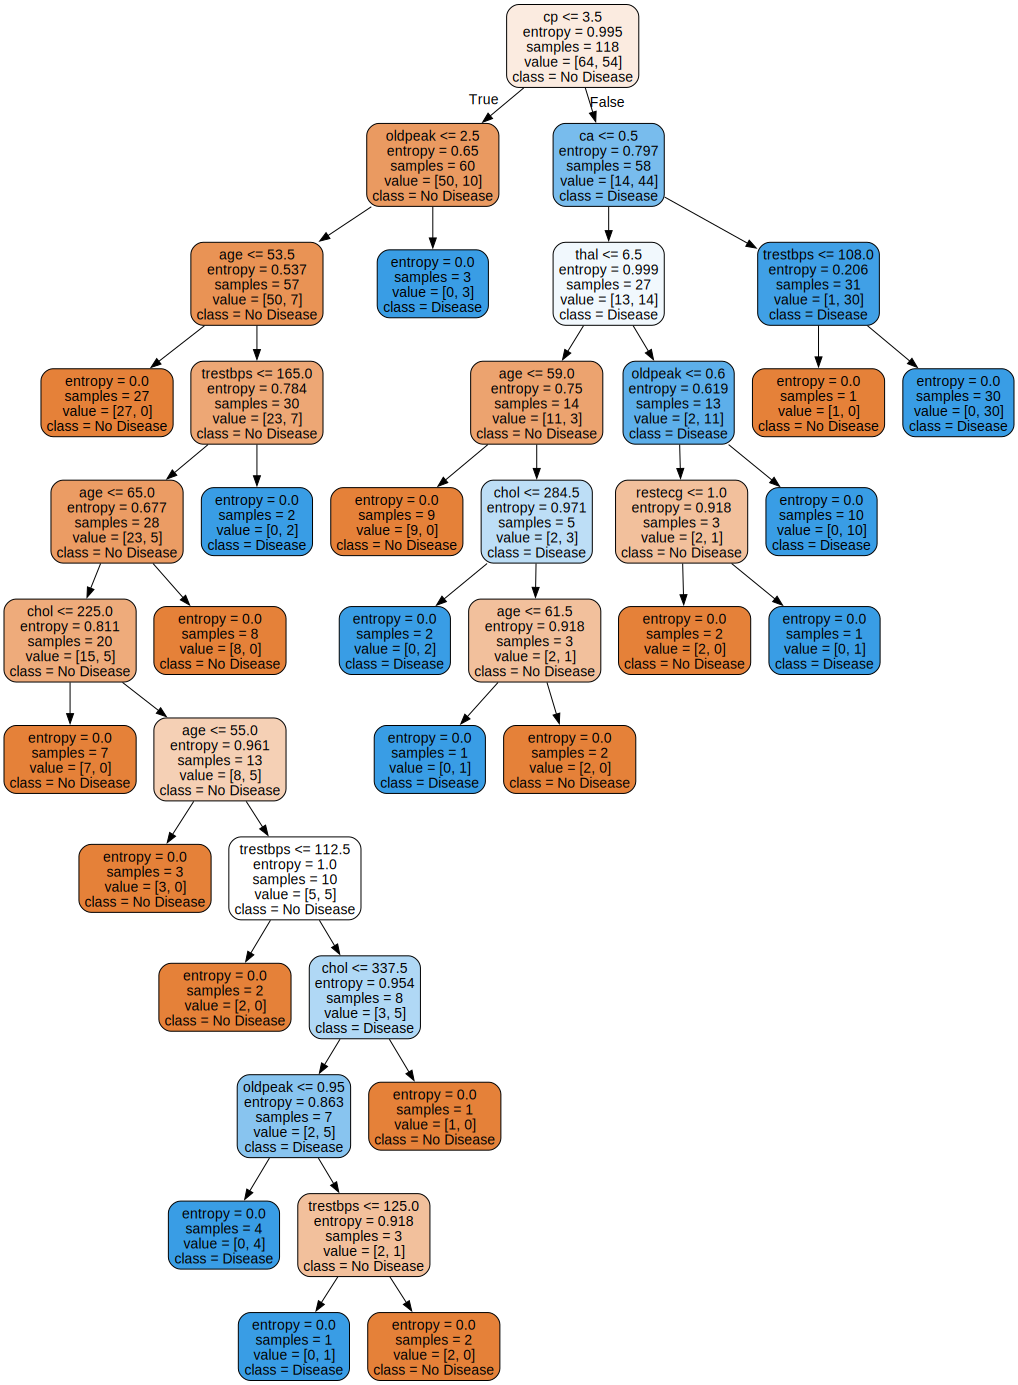

In [414]:
graphs['40/60']

Decision Tree Graph for 60/40 splitting.

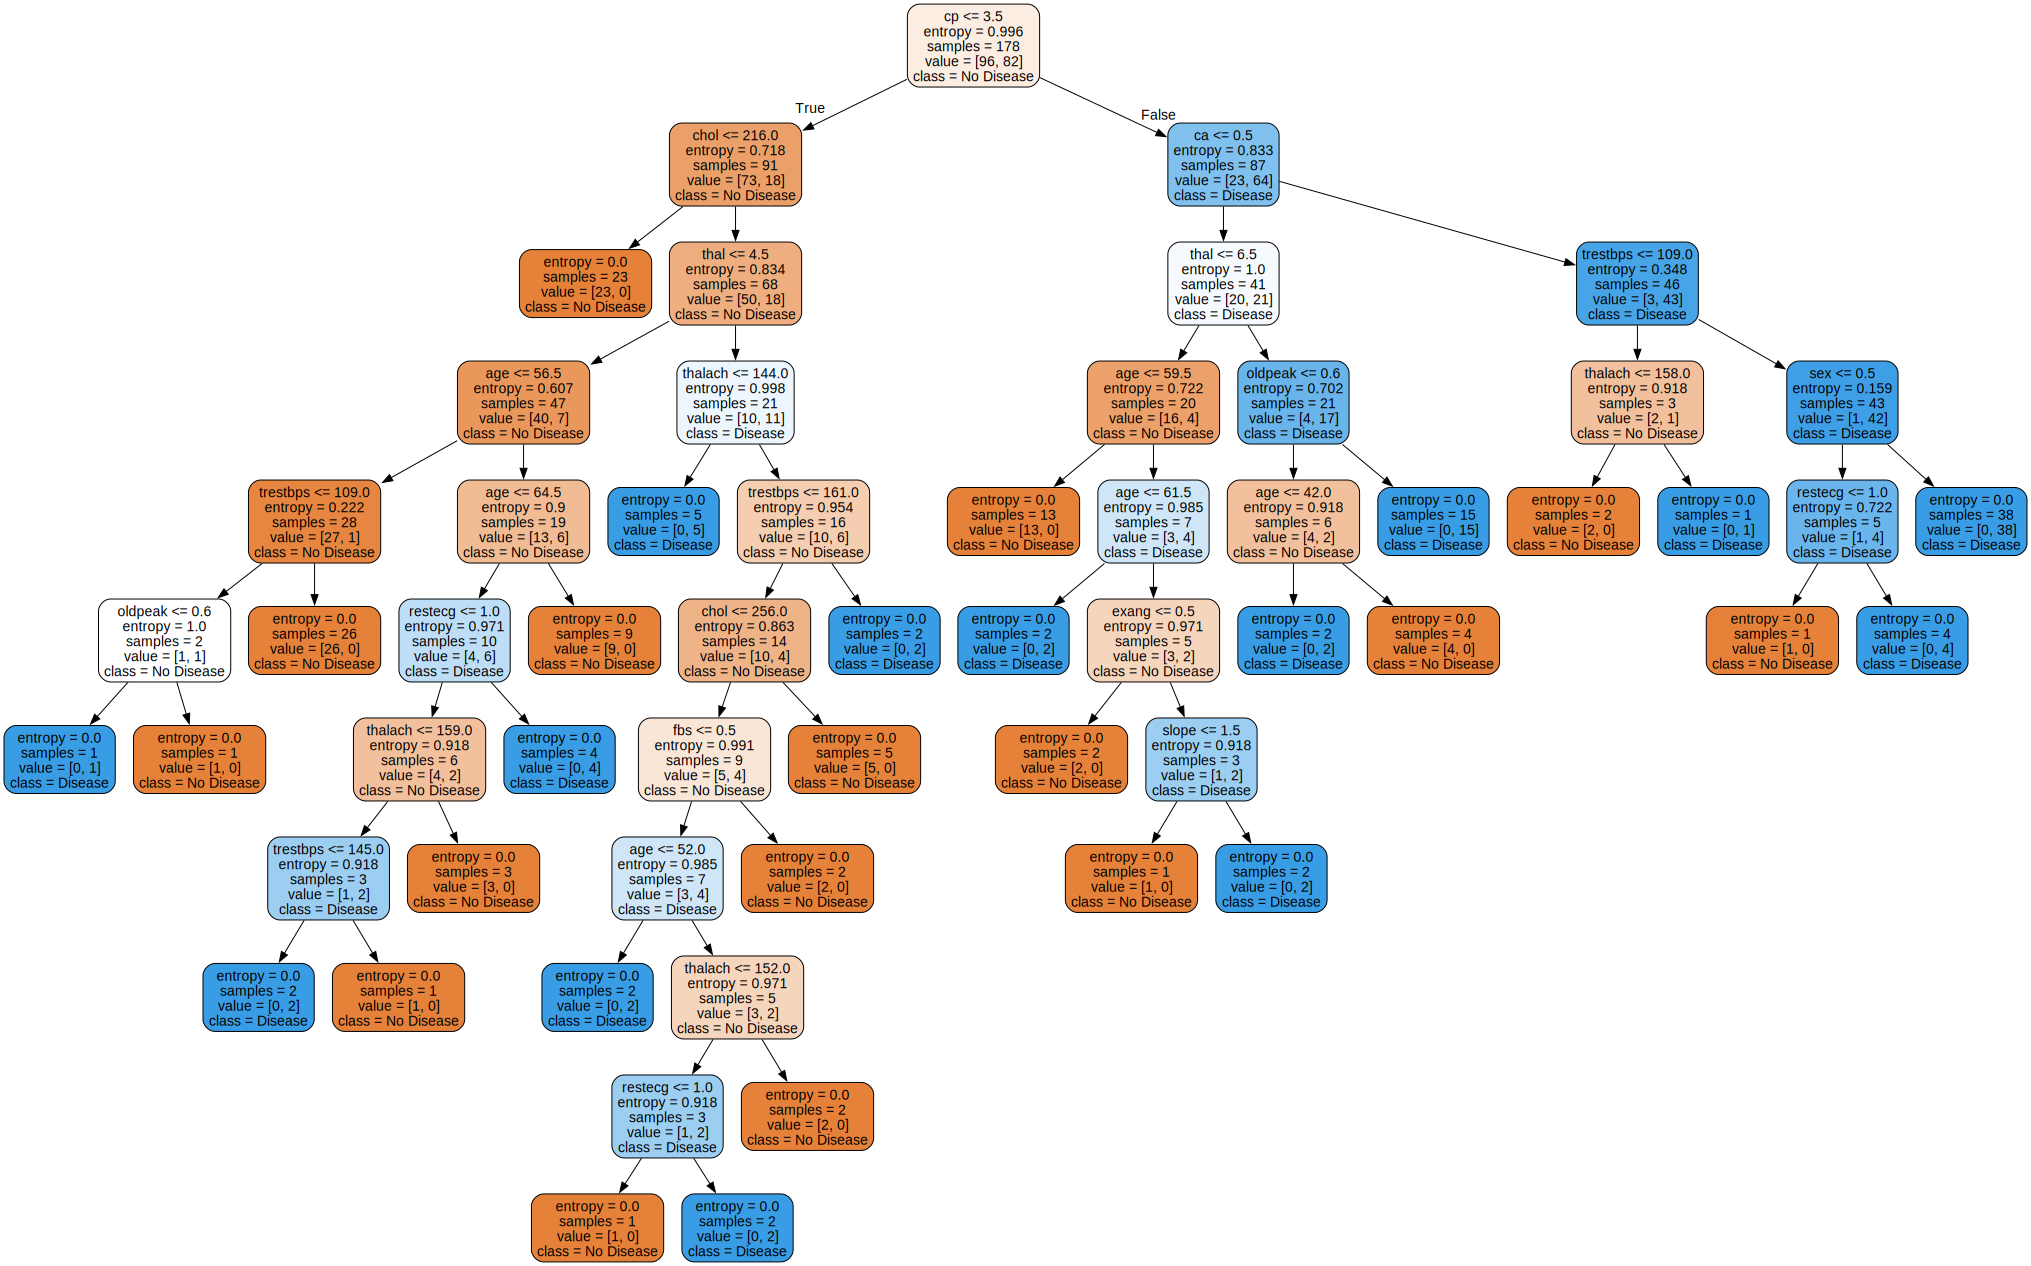

In [415]:
graphs['60/40']

Decision Tree Graph for 80/20 splitting.

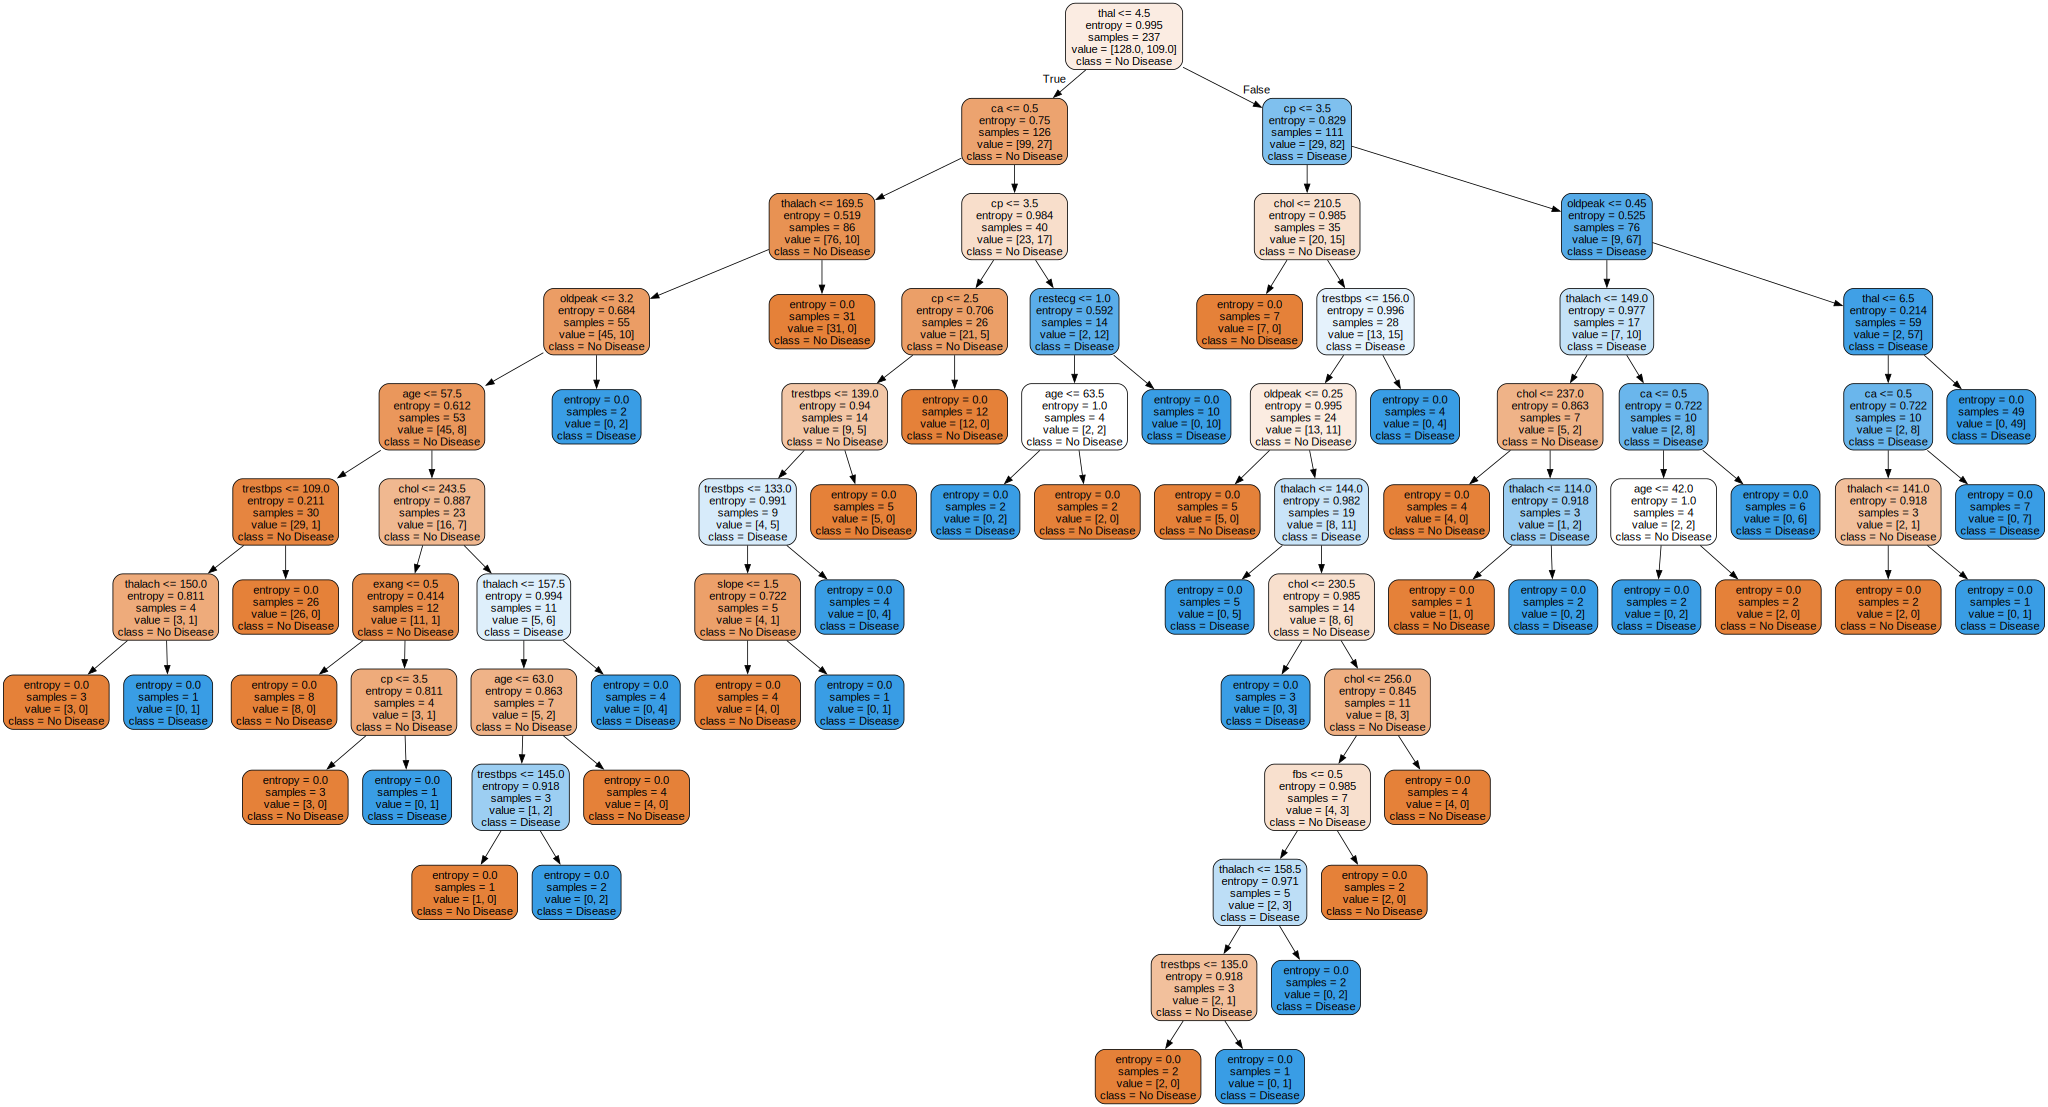

In [416]:
graphs['80/20']

Decision Tree Graph for 90/10 splitting.

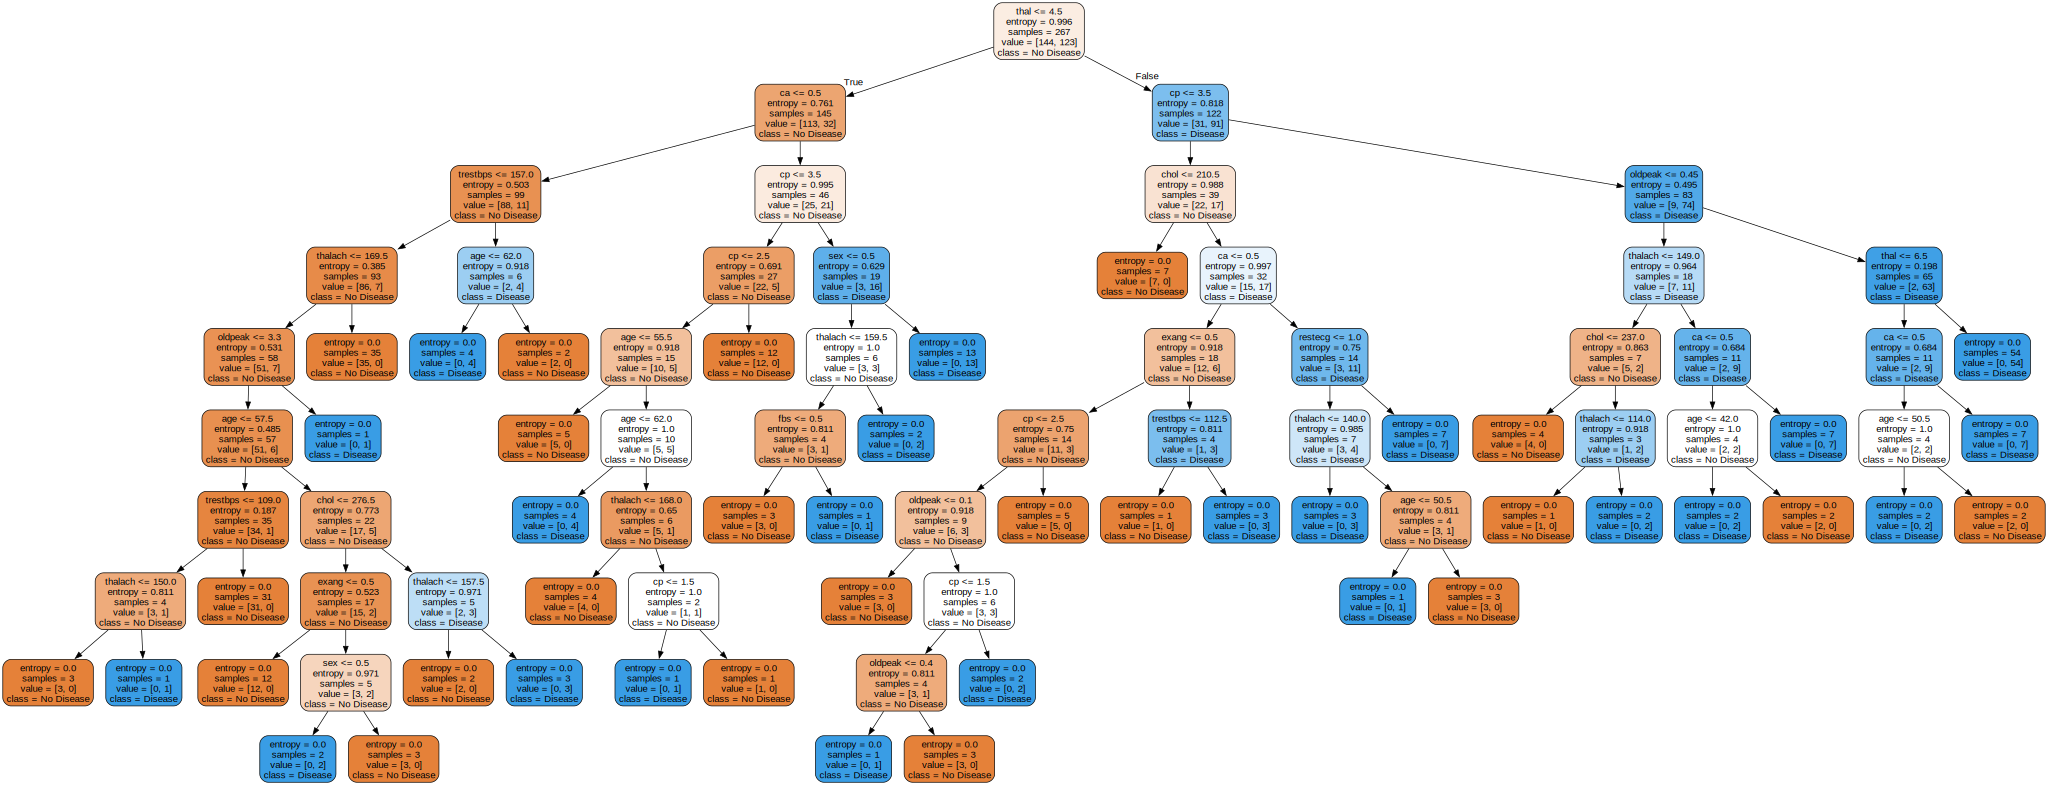

In [417]:
graphs['90/10']

### 3. Evaluating the Decision Tree Classifiers
For each of the trained classifiers, we will predict the samples using test set and generate a report using `classification_report` and `confusion_matrix`.

First, we define the function for displaying necessary information.

In [418]:
reports = {}
conf_matrices = {}

def evaluate_decision_tree_classifier(model, ratio):
    X_test = datasets[ratio]['X_test']
    y_test = datasets[ratio]['y_test'].squeeze()

    y_predicted = model.predict(X_test)

    report = classification_report(y_test, 
                                   y_predicted, 
                                   target_names=custom_labels,
                                   output_dict=True)
    report_df = pd.DataFrame(report).transpose()
    reports[ratio] = report_df

    conf_matrix = confusion_matrix(y_test, y_predicted)
    conf_matrices[ratio] = conf_matrix

def display_evaluation(ratio):
    print("Classification report -----------")
    display(reports[ratio].round(3))

    print("Confusion matrix ----------------")
    depth = models[ratio].get_depth()
    plt.figure(figsize=(8, 6))
    cm_display = ConfusionMatrixDisplay(confusion_matrix=conf_matrices[ratio], display_labels=custom_labels)
    cm_display.plot(cmap='Blues', 
                 values_format='d', 
                 xticks_rotation='vertical', 
                 ax=plt.gca())
    plt.title(f"Confusion Matrix (Depth={depth}, {ratio} Split)")
    plt.tight_layout()
    plt.xticks(rotation=0)
    plt.yticks(rotation=90)
    plt.grid(False)
    plt.show()

for ratio, model in models.items():
    evaluate_decision_tree_classifier(model, ratio)

#### a. 40/60 Splitting

Classification report -----------


,precision,recall,f1-score,support
No Disease,0.775,0.823,0.798,96.000
Disease,0.779,0.723,0.750,83.000
accuracy,0.777,0.777,0.777,0.777
macro avg,0.777,0.773,0.774,179.000
weighted avg,0.777,0.777,0.776,179.000


Confusion matrix ----------------


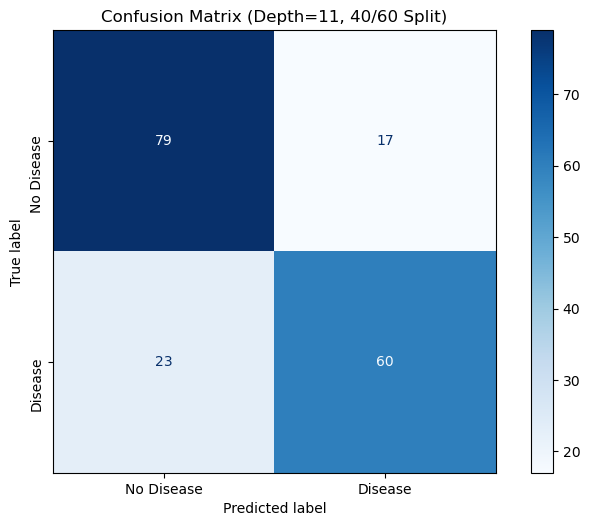

In [419]:
display_evaluation('40/60')

#### Evaluation and insights:
**Classification Report:** 
- `No Disease`: Precision at 0.775 shows effective identification of "No Disease," with few false positives. The recall of 0.823 indicates strong detection of actual "No Disease" cases, minimizing false negatives. The F1-score of 0.798 reflects a good balance, though slightly improved precision could further enhance performance.
- `Disease`: With a precision of 0.779, the model accurately predicts "Disease" most of the time, reducing false positives. The recall of 0.723 suggests reasonable detection of true "Disease" cases but leaves room for improvement to catch more positives. An F1-score of 0.750 indicates balanced performance, but increasing recall would improve overall sensitivity.

**Confusion Matrix:**
- The model accurately identified 79 "No Disease" cases, showing strong capability in detecting healthy individuals.
- 23 true "Disease" cases were missed, suggesting a need to enhance recall for better disease detection.

#### b. 60/40 Splitting

Classification report -----------


,precision,recall,f1-score,support
No Disease,0.724,0.859,0.786,64.000
Disease,0.791,0.618,0.694,55.000
accuracy,0.748,0.748,0.748,0.748
macro avg,0.757,0.739,0.740,119.000
weighted avg,0.755,0.748,0.743,119.000


Confusion matrix ----------------


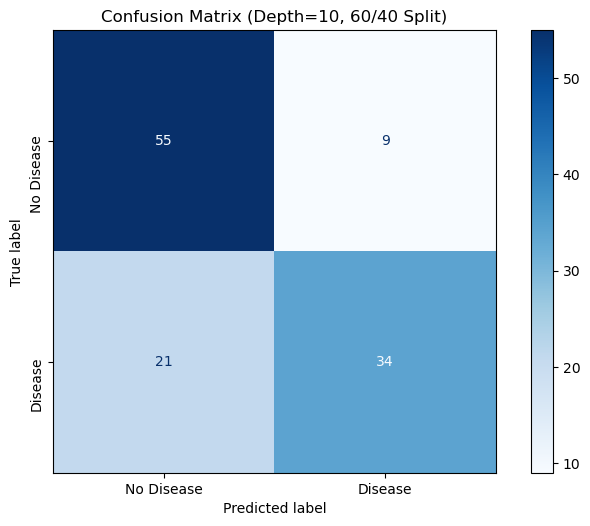

In [420]:
display_evaluation('60/40')

#### Evaluation and insights:
**Classification Report:** 
- `No Disease`: Precision at 0.724 suggests occasional misclassification of "Disease" as "No Disease," which can be misleading. The high recall of 0.859 means the model effectively identifies most "No Disease" cases, minimizing false negatives. The F1-score of 0.786 underscores strong recall, though better precision would enhance overall performance.
- `Disease`: A precision of 0.791 indicates that when "Disease" is predicted, it's usually correct, with few false positives. However, the recall of 0.618 reveals that many true "Disease" cases are missed, which is concerning for accurate diagnosis. The F1-score of 0.694 highlights the need to improve recall to ensure comprehensive detection of "Disease."

**Confusion Matrix:**
- The model successfully identified 55 "No Disease" cases, indicating strong performance in recognizing healthy individuals.
- 21 false negatives: A significant number of "Disease" cases were missed, indicating a need to improve recall and reduce false negatives.
- The model correctly identified 34 cases of "Disease," but the high number of false negatives indicates room for improvement.


#### c. 80/20 Splitting

Classification report -----------


,precision,recall,f1-score,support
No Disease,0.800,0.750,0.774,32.000
Disease,0.733,0.786,0.759,28.000
accuracy,0.767,0.767,0.767,0.767
macro avg,0.767,0.768,0.766,60.000
weighted avg,0.769,0.767,0.767,60.000


Confusion matrix ----------------


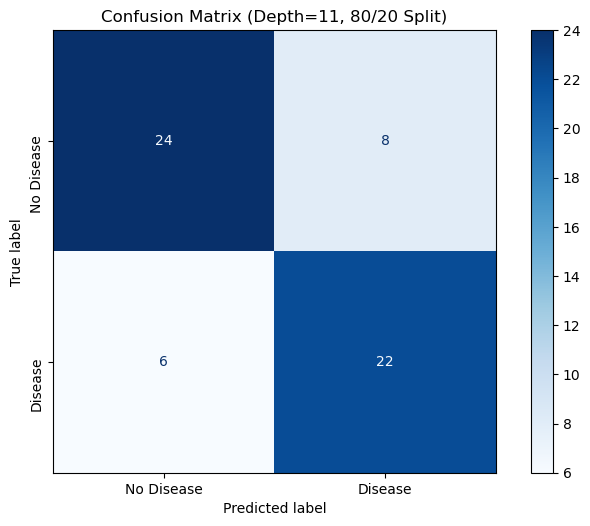

In [421]:
display_evaluation('80/20')

#### Evaluation and insights:
**Classification Report:** 
- `No Disease`: With a precision of 0.800, the model is effective at correctly identifying "No Disease" cases, minimizing false positives. However, the recall of 0.750 indicates it misses 25% of actual "No Disease" cases, which could lead to overlooking healthy individuals. The F1-score of 0.774 reflects a good balance between precision and recall, suggesting overall reliable performance but room for improvement in recall.
- `Disease`: The precision of 0.733 shows that the model often predicts "Disease" correctly, though some false positives occur. A recall of 0.786 indicates it captures most "Disease" cases, but still misses some, leading to false negatives. The F1-score of 0.759 suggests a decent balance, but enhancing precision could reduce false positives and improve detection accuracy.

**Confusion Matrix:**
- The model correctly identified 24 cases as "No Disease" and 22 cases as "Disease". This balance suggests the model is effective in diagnosing both conditions, minimizing bias towards either.
- 8 cases were incorrectly classified as "No Disease" when they actually had the disease. This indicates a need for better precision to reduce misclassification.
- 6 actual "No Disease" cases were missed, leading to potential oversight of healthy individuals. Improving recall could address this.

#### d. 90/10 Splitting

Classification report -----------


,precision,recall,f1-score,support
No Disease,0.684,0.812,0.743,16.0
Disease,0.727,0.571,0.640,14.0
accuracy,0.700,0.700,0.700,0.7
macro avg,0.706,0.692,0.691,30.0
weighted avg,0.704,0.700,0.695,30.0


Confusion matrix ----------------


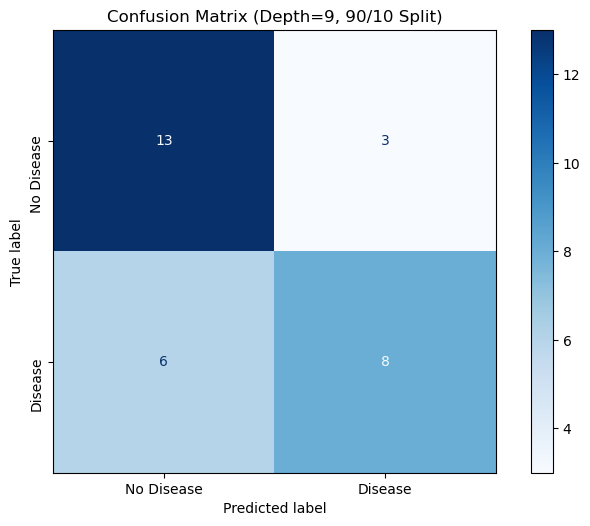

In [422]:
display_evaluation('90/10')

#### Evaluation and insights:
**Classification Report:** 
- `No Disease`: The model exhibits a precision of 0.684 and a recall of 0.812, resulting in an F1-score of 0.743. This indicates that while the model effectively identifies instances of "No Disease" with a high recall, it has moderate precision, suggesting the presence of some false positives.
- `Disease`: The model shows a precision of 0.727 and a recall of 0.571, leading to an F1-score of 0.640. This reflects decent precision but relatively low recall, indicating that the model misses a significant number of actual disease cases.
- Overall, the model achieves an accuracy of 70%, and the macro average F1-score is 0.691, highlighting a slight imbalance in how the model treats both classes.

**Confusion Matrix:**
- The model misclassified 6 "Disease" cases as "No Disease," indicating a significant challenge in its predictive accuracy. This misclassification highlights the model's tendency to prioritize avoiding false alarms, as evidenced by its high recall for the "No Disease" category. 
- However, this focus on minimizing false positives comes at the cost of missing actual disease instances, suggesting a need for improvement in the model's ability to balance sensitivity and specificity.

#### e. Overall Insights
- Across all splits, models show strong recall for "No Disease," ensuring healthy individuals are correctly identified. 
- However, recall for "Disease" is often not as good, indicating a need for better sensitivity to avoid missing true cases. Improving this aspect would enhance the model's utility in medical diagnostics.

### 4. The Depth and Accuracy of a Decision Tree (80/20 Splitting)

In this section, the task focuses on the 80/20 splitting. We are specifying the maximum depth of a decision tree by testing with the following values: `[None, 2, 3, 4, 5, 6, 7]`. For each depth value, the processing procedure will be: providing the decision tree, visualizing using Graphviz, reporting and visualizing the `accuracy_score`.

As the 80/20 dataset was preprocessed above, we will skip this section.

#### a. Preparing
However, we still have to prepare the testing values.

In [423]:
max_depth_values = [None, 2, 3, 4, 5, 6, 7]

X_train = datasets['80/20']['X_train']
y_train = datasets['80/20']["y_train"].squeeze()
X_test = datasets['80/20']["X_test"]
y_test = datasets['80/20']["y_test"].squeeze()

#### b. Model Training
Now we start to apply the `DecisionTreeClassifier` on the dataset with each depth value while analyzing the accuracy for that specific tree and obtaining the corresponding illustration with the help of `Graphviz`.

In [424]:

models = {}
graphs = {}
accuracies = {}


for max_depth in max_depth_values:
    depth_label = f"Depth={max_depth if max_depth else 'None'}"
    model = tree.DecisionTreeClassifier(criterion='entropy', random_state=42, max_depth=max_depth)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    accuracies[depth_label] = accuracy

    models[depth_label] = model
    dot_data = tree.export_graphviz(model, 
                                    out_file=None, 
                                    feature_names=list(X.columns),
                                    class_names=custom_labels,
                                    filled=True, 
                                    rounded=True)
    graph = graphviz.Source(dot_data)

    graphs[depth_label] = graph


#### c. Visualization
The visualization of the resulting decision trees is processed with `Graphviz`.

Depth = `None`

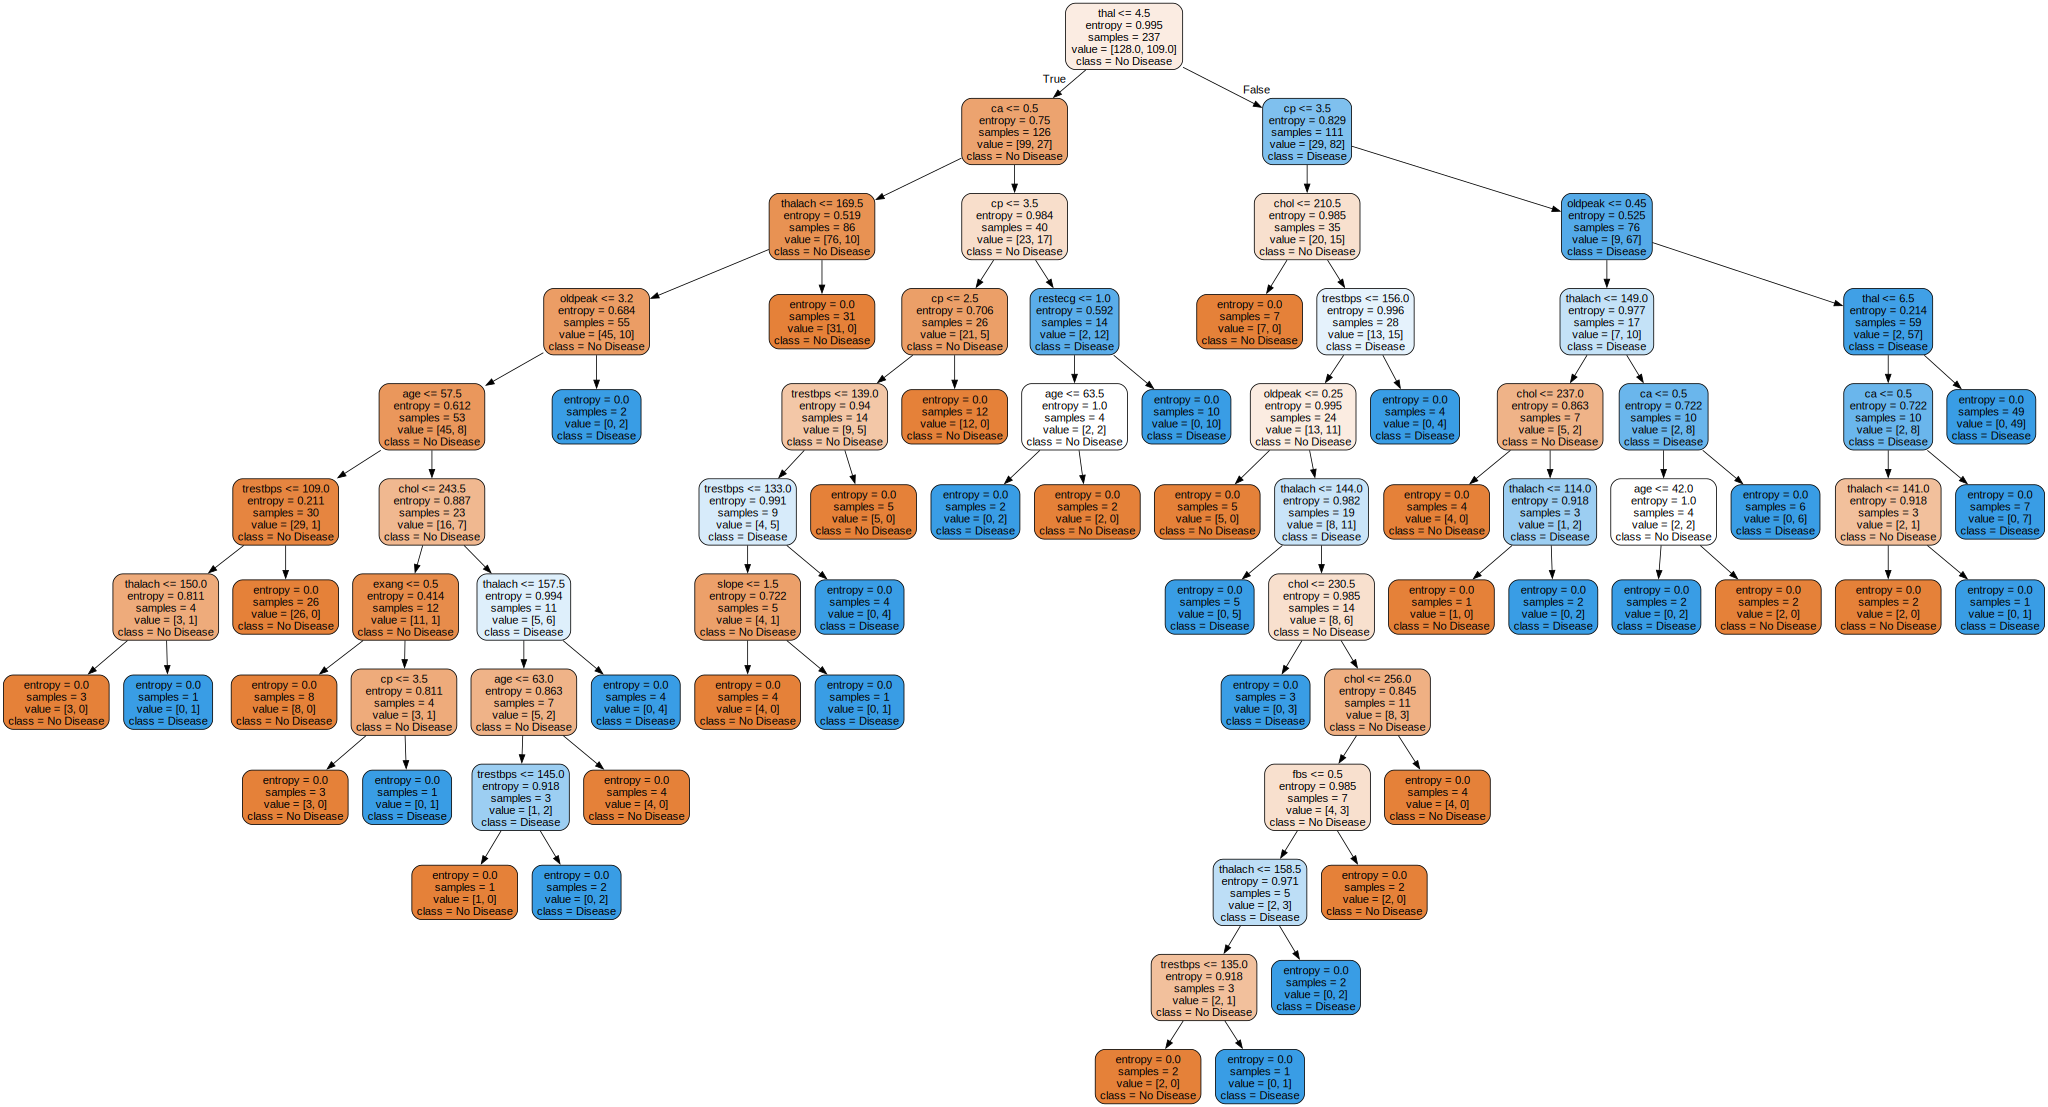

In [425]:
graphs['Depth=None']

Depth = `2`

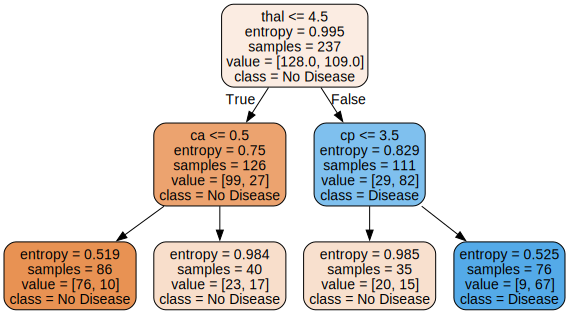

In [426]:
graphs['Depth=2']

Depth = `3`

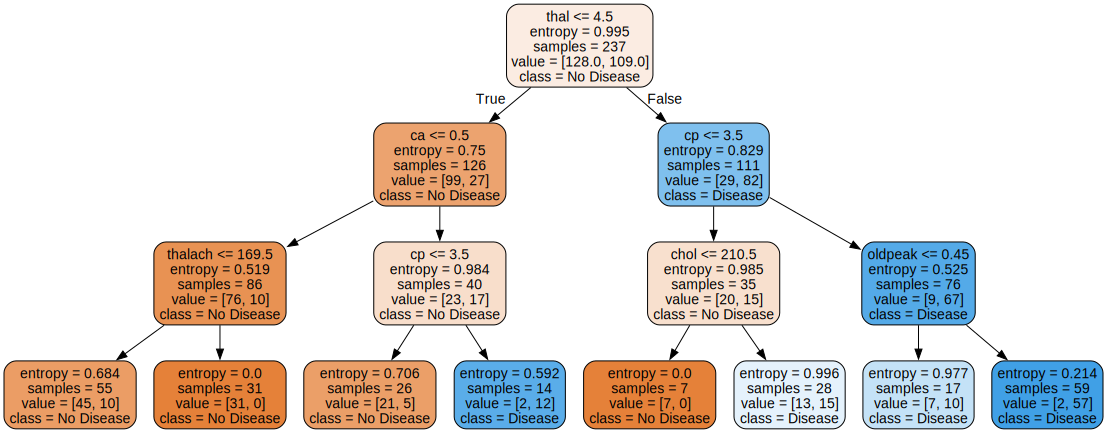

In [427]:
graphs['Depth=3']

Depth = `4`

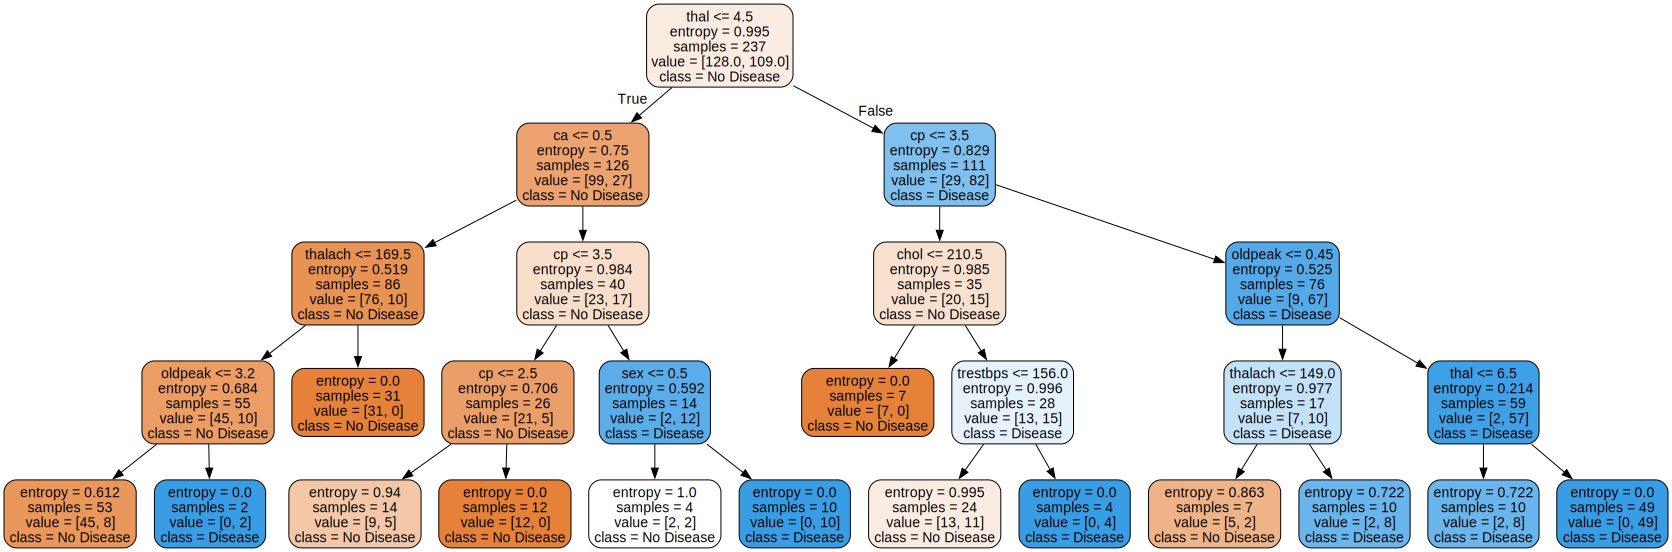

In [428]:
graphs['Depth=4']

Depth = `5`

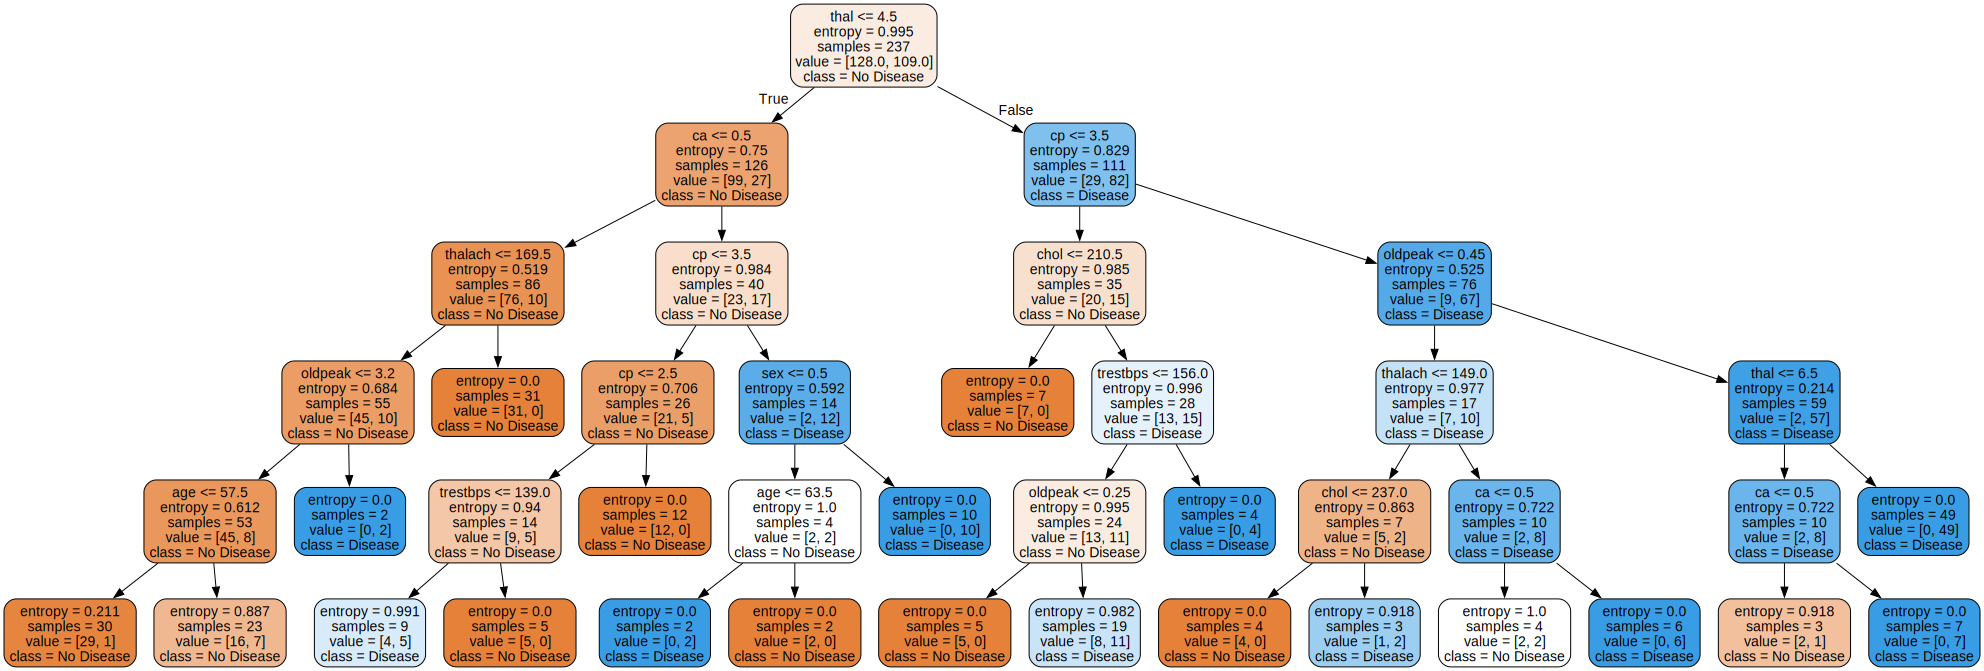

In [429]:
graphs['Depth=5']

Depth = `6`

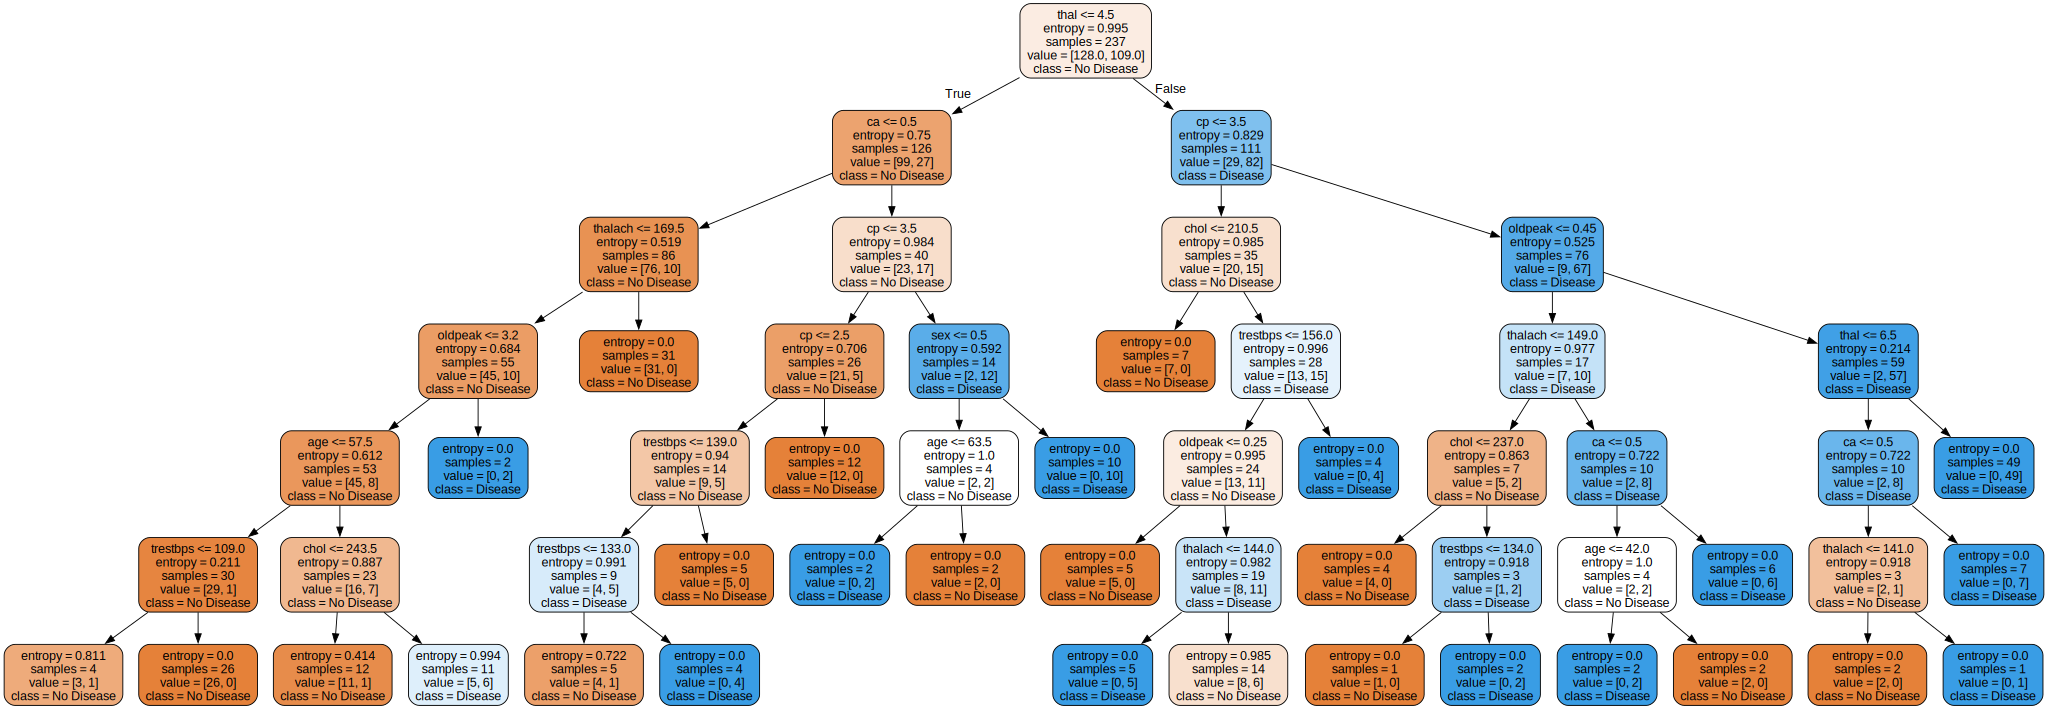

In [430]:
graphs['Depth=6']

Depth = `7`

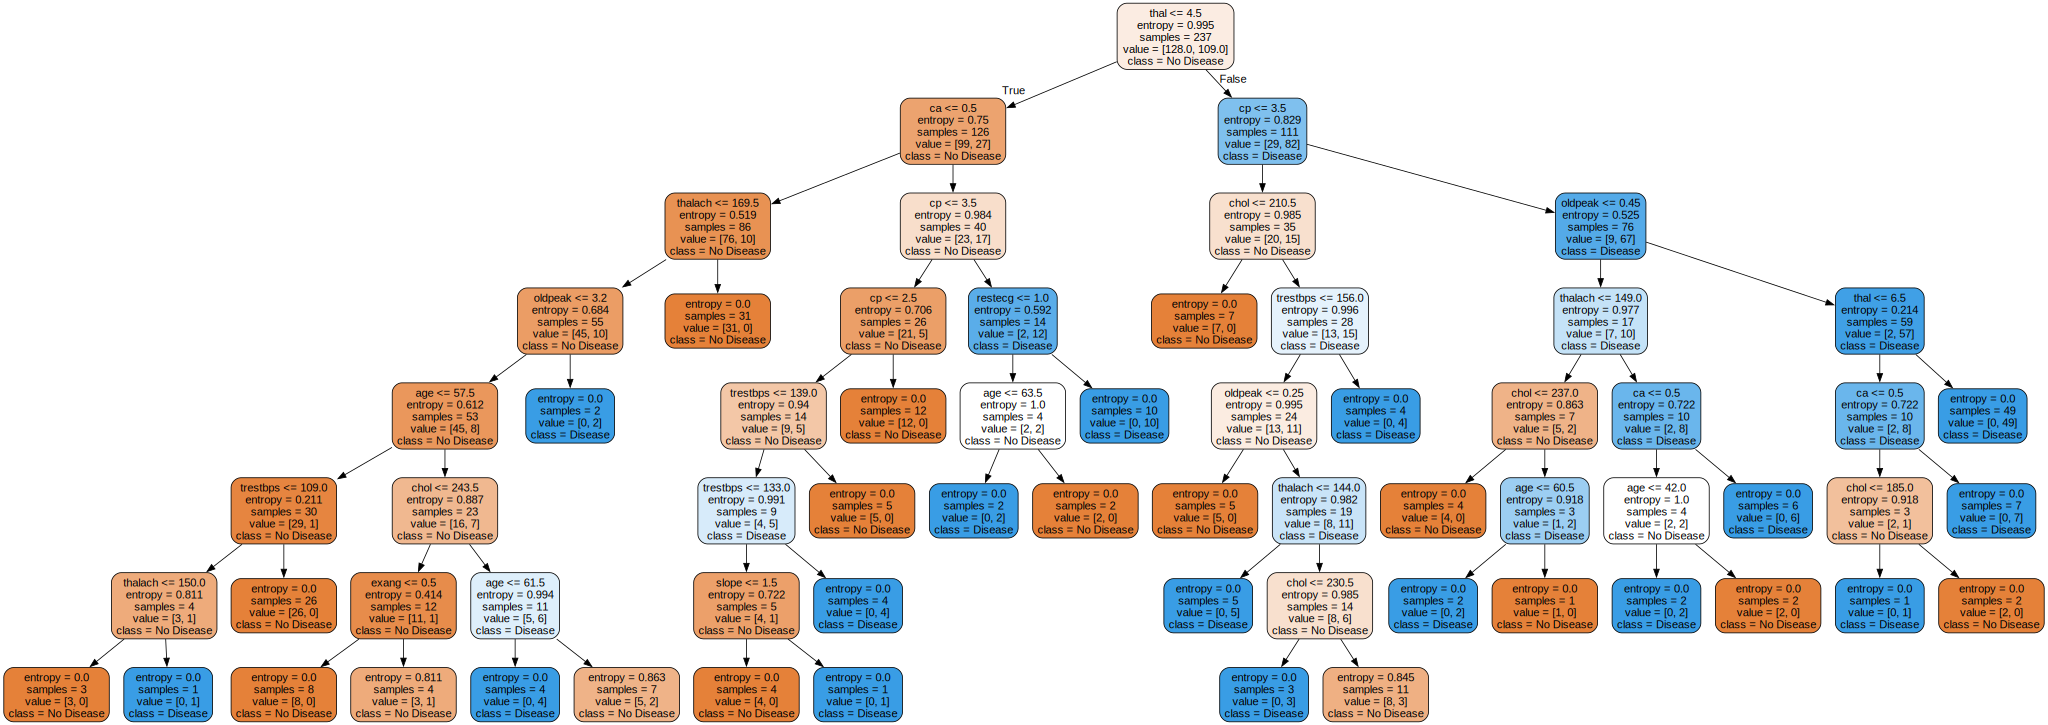

In [431]:
graphs['Depth=7']

#### d. Accuracy Scores

Finally, we will calculate the accuracy scores for each depth value on the test set of the decision tree classifier.

In [432]:
flat_scores = {
    key.replace("Depth=", ""): value
    for key, value in accuracies.items()
}

flat_scores = dict(sorted(
    flat_scores.items(),
    key=lambda x: 1 if x[0] == "None" else int(x[0])
))

accuracy_table = pd.DataFrame([flat_scores], index=["Accuracy"]).round(4)

display(accuracy_table)

,None,2,3,4,5,6,7
Accuracy,0.7667,0.7167,0.8167,0.7667,0.7667,0.7333,0.7667


For drawing insights and easy interpretation, we now plot a chart for accuracy values.

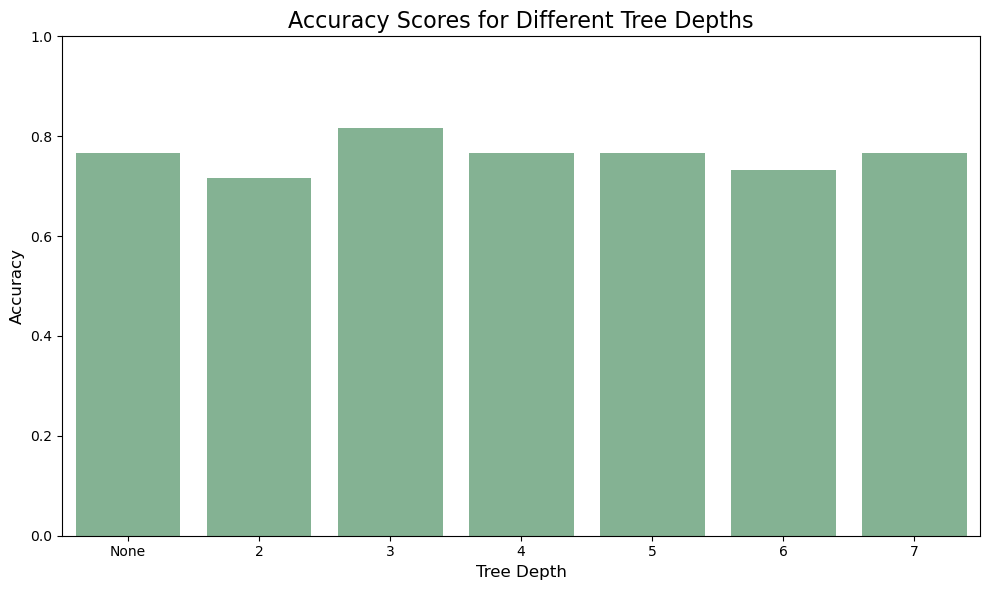

In [433]:
plt.figure(figsize=(10, 6))
sns.barplot(x=list(flat_scores.keys()), y=list(flat_scores.values()))
plt.title("Accuracy Scores for Different Tree Depths", fontsize=16)
plt.xlabel("Tree Depth", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.xticks()
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

#### e. Overall Insights
The accuracy scores for the decision tree classifier with varying maximum depths reveal the following observations:
- As the maximum depth of the decision trees increases from 2 to 7, the accuracy values fluctuate, with the highest accuracy of 0.8167 achieved at a maximum depth of 3.
- The accuracy values at depths 2, 4, 5, and 7 are all 0.7667, indicating that the model's performance is consistent at these depths. 
- The lowest accuracy of 0.7333 is observed at a maximum depth of 6.
- Overall, the data suggests that the model's performance is sensitive to the maximum depth of the decision trees, and a depth of 3 seems to provide the best accuracy for this particular classification task.


- Typically, as the maximum depth of decision trees increases, the model's ability to capture more complex patterns in the data also increases, which should lead to a proportional increase in the accuracy.  The fluctuations in accuracy across different depths suggest that the model may be facing some issues, such as:
  - Overfitting at higher depths, where the model starts to capture noise in the data rather than the underlying patterns.
  - Potential issues with the dataset, such as imbalanced classes or high levels of noise, which can make it difficult for the model to learn effectively as the depth increases.


## Overall Dataset Insights
 - 303 instances is a relatively small dataset, especially for a supervised learning task like this.
 - With a small dataset, the model's ability to generalize effectively can be limited, and it may be more prone to overfitting as the complexity of the model (in this case, the maximum depth of the decision trees) increases. Specifically, at lower depths (2-3), the model is able to capture the underlying patterns in the limited data reasonably well, leading to the observed increase in accuracy up to a depth of 3. However, as the depth increases further (4-7), the model starts to overfit to the training data, leading to the fluctuations and even a decrease in accuracy. The model is likely capturing noise and idiosyncrasies in the small dataset rather than generalizable patterns.